In [1]:
# Import libraries

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt

In [2]:
# Set using gpu if one has, cpu otherwise

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Specify the path to the image data

DATA_DIR  = Path("data")
TRAIN_DIR = DATA_DIR / "RealWaste"

In [4]:
# Preprocess and transform the train and validation data 

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]), # ImageNet mean, std
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [5]:
# Split the train, test, and validation test set


# Spcify the Image folder
base_ds = ImageFolder(TRAIN_DIR)
indices = list(range(len(base_ds)))
labels  = [label for _, label in base_ds.samples] # Extract the label names

# Train - Test: 0.8 - 0.2
train_val_idx, test_idx, train_val_labels, test_labels = train_test_split(
    indices, labels,
    train_size=0.8,
    stratify=labels,
    random_state=42
)

# Train - Val: 0.8 - 0.2
train_idx, val_idx, _, _ = train_test_split(
    train_val_idx, train_val_labels,
    test_size=0.20,
    stratify=train_val_labels,
    random_state=42
)

len(train_idx),  len(val_idx), len(test_idx)

(3040, 761, 951)

In [6]:
# Split the data and transform them using Subset. Also, load them into DataLoader
train_ds = Subset(ImageFolder(TRAIN_DIR, transform=train_transforms), train_idx)
val_ds   = Subset(ImageFolder(TRAIN_DIR, transform=val_transforms), val_idx)
test_ds  = Subset(ImageFolder(TRAIN_DIR, transform=val_transforms), test_idx)

train_loader = DataLoader(train_ds,  batch_size=64, shuffle=True,  num_workers=12)
val_loader   = DataLoader(val_ds,    batch_size=64, shuffle=False, num_workers=12)
test_loader  = DataLoader(test_ds,   batch_size=64, shuffle=False, num_workers=12)

len(train_ds), len(val_ds), len(test_ds)

(3040, 761, 951)

In [15]:
# Define the custom CNN model structure
class CustomCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()

        # Layer 1: conv 3 -> 32 (3x3 kernel, 1 padding, 1 stride), batch norm, ReLU, then 2x2 max pooling
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2) 
        )

        # Layer 2: conv 32 -> 64 (3x3 kernel, 1 padding, 1 stride),  batch norm, ReLU, then 2x2 max pooling
        self.layer_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        
        # Layer 3: conv 64 -> 128 (3x3 kernel, 1 padding, 1 stride), batch norm, ReLU, then 2x2 max pooling
        self.layer_3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        # Layer 4: Conv 128 -> 256 (3x3 kernel, 1 padding, 1 stride),  batch norm, ReLU, then 2x2 max pooling
        self.layer_4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        # Layer 5: Conv 256 -> 512 (3x3 kernel, 1 padding, 1 stride), batch norm, ReLU, then 2x2 max pooling
        self.layer_5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)   
        )

        # Layer 6: fully connected dropout (0.5), flatten, dense to 256, batch norm, ReLU, dropout (0.5), final output
        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, model):
        
        model = self.layer_1(model)  
        model = self.layer_2(model) 
        model = self.layer_3(model)  
        model = self.layer_4(model)   
        model = self.layer_5(model) 

        model = self.fc(model)
        
        return model

In [16]:
# Get the number of classes
num_classes = len(base_ds.classes)

# Initialzie the model and send it to the target computation system
model = CustomCNN(num_classes).to(device)

# Define loss function (cross-entropy for multi-class classification)
cross_entropy_loss = nn.CrossEntropyLoss()

# Configure SGD optimizer with momentum and weight decay (L2 regularization)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4) # learning rate: 1e-3, momentum = 0.9, weight dacay = 5e-4 for initial

# Define the scheduler for the model (OneCycleLR - learning rate chagnes every epoch)
scheduler = OneCycleLR( 
    optimizer,
    max_lr=1e-3, # max learning rate
    final_div_factor=1e4, # final LR = max_lr / final_div_factor
    
    steps_per_epoch=len(train_loader), # iterations per epoch
    epochs=20,   # total number of epochs
)

In [17]:
# Dictionary for storing history (accuracies and losses during training)
history = {
    "train_acc":[], 
    "train_loss":[], 
    "val_acc":[], 
    "val_loss":[]
}

# Define the number of epoch
num_epochs   = 20


for epoch in range(1, num_epochs+1):

    # Train
    model.train()
    
    # Initialize running totals for this epoch for train
    running_loss, all_preds, all_labels = 0.0, [], []
    
    for imgs, labels in train_loader:
        # Move images and labels to the computation device
        imgs, labels = imgs.to(device), labels.to(device)

        # clear previous gradients from last step
        optimizer.zero_grad()

        # forward
        outputs = model(imgs)

        # compute loss
        loss = cross_entropy_loss(outputs, labels)
        
        # back propagation
        loss.backward() 
        
        optimizer.step() # update weights
        scheduler.step() # update learning rate
        

        # Accumulate the loss, weighted by batch size
        running_loss += loss.item() * imgs.size(0)

        # Store the predicted labels and true labels
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Compute average training loss and overall training accuracy
    train_loss = running_loss / len(train_loader.dataset)
    train_acc  = accuracy_score(all_labels, all_preds)

    
    # validation
    
    model.eval()

    # Initialize running totals for this epoch for validation
    running_loss, all_preds, all_labels = 0.0, [], []
    with torch.no_grad(): # no gradient computation during validation for not affecting back prop or updating weights
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            # forward
            outputs = model(imgs)

            # computer loss
            loss = cross_entropy_loss(outputs, labels)

            
            running_loss += loss.item() * imgs.size(0)
            
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Compute average validation loss and overall validation accuracy
    val_loss = running_loss / len(val_loader.dataset)
    val_acc  = accuracy_score(all_labels, all_preds)

    # Print out losses and accuracies for each epoch
    print(f"Epoch {epoch}: Train Loss {train_loss:.3f}, Accuracy {train_acc:.3f} | Val Loss {val_loss:.3f}, Accuracy {val_acc:.3f}")

    # Store the accuracies and losses in history
    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc)
    history["val_loss"].append(val_loss)




Epoch 1: Train Loss 2.236, Accuracy 0.163 | Val Loss 1.923, Accuracy 0.372
Epoch 2: Train Loss 1.893, Accuracy 0.334 | Val Loss 1.568, Accuracy 0.451
Epoch 3: Train Loss 1.655, Accuracy 0.412 | Val Loss 1.399, Accuracy 0.532
Epoch 4: Train Loss 1.490, Accuracy 0.474 | Val Loss 1.277, Accuracy 0.564
Epoch 5: Train Loss 1.401, Accuracy 0.512 | Val Loss 1.187, Accuracy 0.578
Epoch 6: Train Loss 1.327, Accuracy 0.534 | Val Loss 1.308, Accuracy 0.531
Epoch 7: Train Loss 1.280, Accuracy 0.550 | Val Loss 1.090, Accuracy 0.599
Epoch 8: Train Loss 1.218, Accuracy 0.561 | Val Loss 1.059, Accuracy 0.615
Epoch 9: Train Loss 1.178, Accuracy 0.583 | Val Loss 1.004, Accuracy 0.641
Epoch 10: Train Loss 1.135, Accuracy 0.605 | Val Loss 1.014, Accuracy 0.633
Epoch 11: Train Loss 1.132, Accuracy 0.600 | Val Loss 1.028, Accuracy 0.639
Epoch 12: Train Loss 1.089, Accuracy 0.614 | Val Loss 0.919, Accuracy 0.666
Epoch 13: Train Loss 1.082, Accuracy 0.619 | Val Loss 1.033, Accuracy 0.627
Epoch 14: Train Loss 

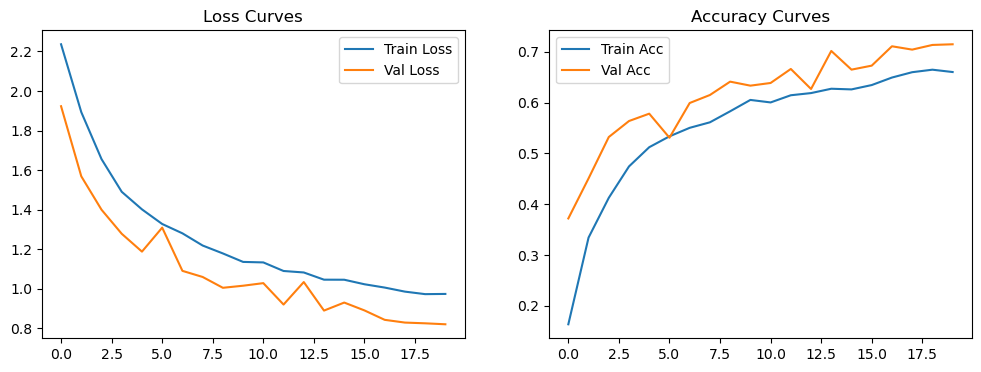

In [18]:
# Loss and accuracy curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"],   label="Val Loss")
plt.legend(); plt.title("Loss Curves")

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"],   label="Val Acc")
plt.legend(); plt.title("Accuracy Curves")
plt.show()


In [19]:
# Test accuracy and evaluation report
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        test_preds.extend(outputs.argmax(1).cpu().numpy())
        test_labels.extend(labels.numpy())

print("Test Accuracy:", accuracy_score(test_labels, test_preds))
print(classification_report(test_labels, test_preds, target_names=base_ds.classes))
#print("Confusion Matrix:\n", confusion_matrix(test_labels, test_preds))

Test Accuracy: 0.7287066246056783
                     precision    recall  f1-score   support

          Cardboard       0.81      0.77      0.79        92
      Food Organics       0.78      0.84      0.81        82
              Glass       0.72      0.69      0.70        84
              Metal       0.76      0.80      0.78       158
Miscellaneous Trash       0.57      0.44      0.50        99
              Paper       0.87      0.62      0.73       100
            Plastic       0.68      0.78      0.73       185
      Textile Trash       0.58      0.52      0.55        64
         Vegetation       0.79      0.97      0.87        87

           accuracy                           0.73       951
          macro avg       0.73      0.72      0.72       951
       weighted avg       0.73      0.73      0.72       951



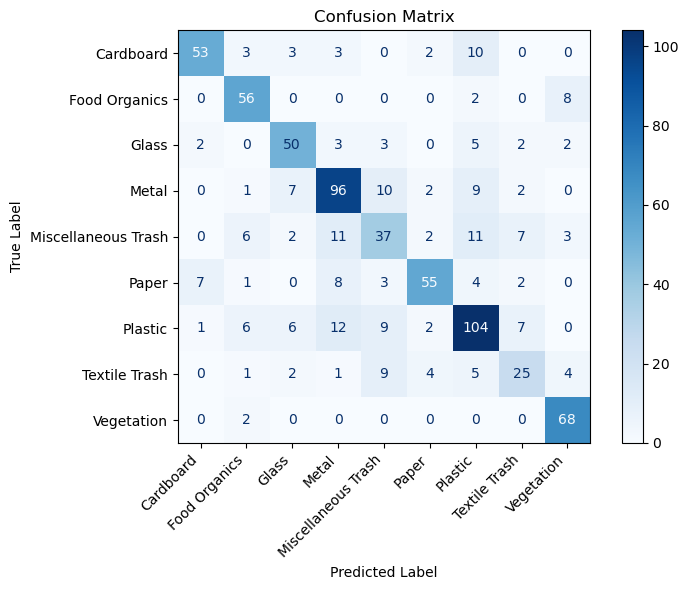

In [20]:
# confusion matrix
cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=base_ds.classes)
disp.plot(ax=ax, cmap=plt.cm.Blues)

ax.set_xticklabels(base_ds.classes, rotation=45, ha="right")
ax.set_ylabel("True Label")
ax.set_xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

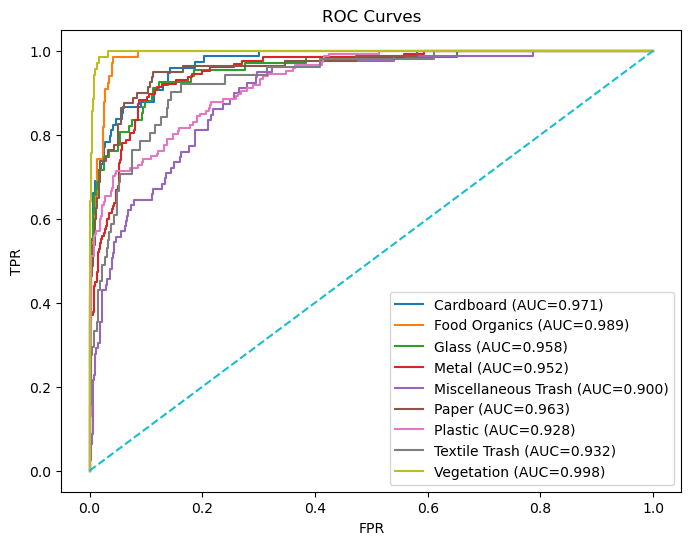

In [21]:
# ROC curves
probs, true = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outs = model(imgs)
        probs.append(torch.softmax(outs, dim=1).cpu().numpy())
        true.append(labels.numpy())

probs = np.vstack(probs)
true  = np.hstack(true)



y_label = label_binarize(true, classes=list(range(len(base_ds.classes))))
fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(base_ds.classes)):
    fpr[i], tpr[i], _ = roc_curve(y_label[:,i], probs[:,i])
    roc_auc[i]        = auc(fpr[i], tpr[i])


plt.figure(figsize=(8,6))

for i, label in enumerate(base_ds.classes):
    plt.plot(fpr[i], tpr[i], label=f"{label} (AUC={roc_auc[i]:.3f})")

plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC Curves") 
plt.legend()
_ = plt.show()
